In [1]:
import torch
import numpy as np
import sys; sys.path.append('../src/'); sys.path.append('..')
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from src.model.utils.metrics import l2_loss, explained_reconstruction, mean_correlation, importance_correlation, main_exprec
from src.toy_experiment import MLP, Adam, generate_configs, read_dataset, DataLoader, VolumeAE
from itertools import product
from torch.nn.functional import mse_loss

In [9]:
ll = [1, 2, 4, 8, 16, 32][:4]
dd = [2, 4, 8, 16, 32]
ii = range(5)
ww = [[32]*4, [48]*4, [64]*4, [96]*4, [128]*4, [256]*4][:4]

recs = torch.zeros(len(ll), len(dd), len(ii))
mses = torch.zeros(len(ll), len(dd), len(ii))

for o, (l, width) in enumerate(zip(ll, ww)):
    for p, d in enumerate(dd):
        rec = []; mse = []
        for i in ii:
            dataset = read_dataset(l, d*l, i)[:]
            configs = generate_configs(d*l, width, 'vol')

            ae = VolumeAE(configs, MLP, MLP, Adam)
            ae.load('../saves/toy-no-SN/{}-man/{}-amb/#{}/0e+00/non20000.tar'.format(l, l*d, i))
            ae.eval()
            
            _rec = l2_loss(ae.decode(ae.encode(dataset)), dataset)
            _mse = mse_loss(ae.decode(ae.encode(dataset)), dataset)
            rec.append(_rec); mse.append(_mse)
        
        recs[o,p] = torch.as_tensor(rec)
        mses[o,p] = torch.as_tensor(mse)

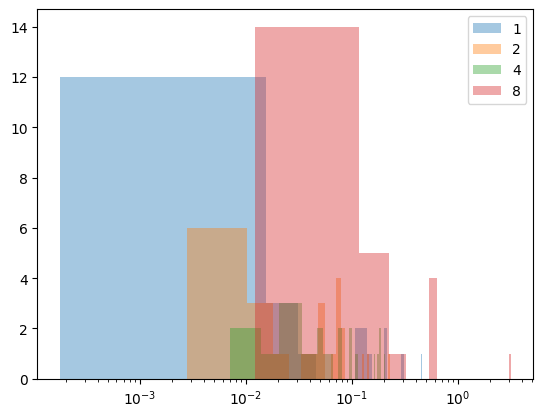

In [20]:
for l, rec in zip(ll, recs):
    plt.hist(rec.flatten().detach().numpy(), alpha=0.4, bins=30, label=l)
plt.xscale('log')
plt.legend()
plt.show()

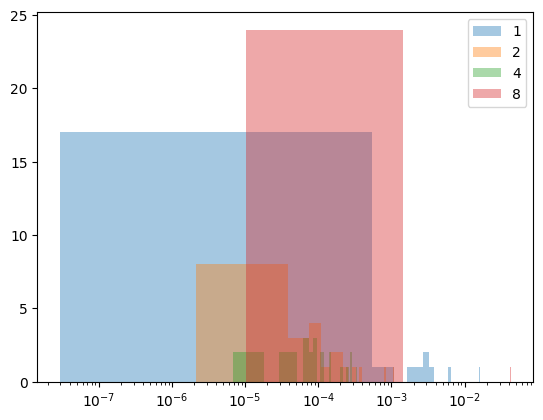

In [19]:
for l, mse in zip(ll, mses):
    plt.hist(mse.flatten().detach().numpy(), alpha=0.4, bins=30, label=l)
plt.xscale('log')
plt.legend()
plt.show()